# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекc Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

**Ход исследования**

Данные о заемщиках мы получим из файла `datasets/real_estate_data.csv`. О качестве данных ничего не известно. Поэтому до выполнения расчётов и проведения исследовательского анализа понадобится обзор данных. 

Мы проверим данные на ошибки и оценим их влияние на исследование. Затем, на этапе предобработки мы поищем возможность исправить самые критичные ошибки данных.
 
Таким образом, предварительно разделим исследование на четыре этапа:
 1. Обзор данных.
 2. Предобработка данных.
 3. Проведение расчётов.
 4. Исследовательский анализ данных.

## Изучение данных из файла

Составим первое впечатление о данных. Для этого сперва импортируем библиотеку `pandas` и метод `pyplot` библиотеки `matplotlib`:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # отключаем предупреждения Pandas
pd.set_option('display.max_columns', 50)  # выводим все столбцы в таблице (до 50 шт.)   

Прежде мы открыли файл в MS Excel - и обратили внимание, что разделителем в данном датасете выступает не привычная запятая, а значок табуляции.

С учетом этого фактора прочитаем файл `real_estate_data.csv` из папки `/datasets` и сохраним его в переменной `df`:

In [2]:
df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

Отобразим первые пять строк таблицы:

In [3]:
display(df.head())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Здесь мы видим, что в датафрейме подавляющим большинством представлены количественные значения; категории указаны в столбцах `is_apartment` и `locality_name`.

Также, мы уже можем наблюдать отсутствующие значения в следующих столбцах:
* `ceiling_height`
* `living_area`
* `is_apartment`
* `kitchen_area`
* `balcony`
* `parks_nearest`
* `ponds_nearest`
* `days_exposition`

К тому же, таблица слишком объёмна - мы можем видеть только двадцать столбцов из имеющихся двадцати двух.

Для получения более полной информации о датафрейме вызовем метод `info()`:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Как мы видим, в датафрейме двадцать два столбца, большинство из них (кроме `cityCenters_nearest`) поименованы в соответствии с общепринятым стилем. Представленные типы данных - `float`, `int`, `bool` и `object`.

Согласно документации к данным:
* `airports_nearest` — расстояние до ближайшего аэропорта в метрах (м)
* `balcony` — число балконов
* `ceiling_height` — высота потолков (м)
* `cityCenters_nearest` — расстояние до центра города (м)
* `days_exposition` — сколько дней было размещено объявление (от публикации до снятия)
* `first_day_exposition` — дата публикации
* `floor` — этаж
* `floors_total` — всего этажей в доме
* `is_apartment` — апартаменты (булев тип)
* `kitchen_area` — площадь кухни в квадратных метрах (м²)
* `last_price` — цена на момент снятия с публикации
* `living_area` — жилая площадь в квадратных метрах (м²)
* `locality_name` — название населённого пункта
* `open_plan` — свободная планировка (булев тип)
* `parks_around3000` — число парков в радиусе 3 км
* `parks_nearest` — расстояние до ближайшего парка (м)
* `ponds_around3000` — число водоёмов в радиусе 3 км
* `ponds_nearest` — расстояние до ближайшего водоёма (м)
* `rooms` — число комнат
* `studio` — квартира-студия (булев тип)
* `total_area` — площадь квартиры в квадратных метрах (м²)
* `total_images` — число фотографий квартиры в объявлении

Количество значений в столбцах различается. Значит, в данных есть пропуски, которые необходимо исследовать.

### Промежуточный вывод
В каждой строке таблицы — данные из объявлений о продаже квартир. Всего представлено двадцать два столбца.

Предварительно можно утверждать, что, данных достаточно для определения рыночной стоимости недвижимости. Однако, во многих столбцах встречаются пропуски. До этапов расчётов и исследовательского анализа необходимо заполнить пропущенные значения - или обосновать их отсутствие.

Интерес представляют и типы данных:
* в столбце `floors_total` указан вещественный тип данных; его оптимальнее перевести в целочисленный, для возможности сравнения со столбцом `floor`;
* столбец `balcony` аналогично лучше перевести в целочисленный формат;
* поскольку столбец `days_exposition` отражает количество дней, то лучший вариант его представления - также целочисленный;
* так как в столбцах `parks_around3000` и `ponds_around3000` значится число парков и прудов соответственно, то их также будет рациональнее перевести в целочисленный формат;
* в документации столбец `is_apartment` указан как булев тип, в таблице же тип его данных указан как `object`;
* столбец с датой публикации `first_day_exposition` удобнее всего будет перевести в формат `datetime`.

Для облегчения работы с данными необходимо привести наименование столбца `cityCenters_nearest` к общему стилю.

Чтобы двигаться дальше, нужно устранить проблемы в данных.

## Предобработка данных

### Стиль заголовков
Приведём столбец `cityCenters_nearest` к общему стилю и сохраним результат в текущий датафрейм:

In [5]:
df = df.rename(columns={'cityCenters_nearest': 'city_centers_nearest'})

Проверим результат при помощи `columns`:

In [6]:
df.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_centers_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

### Заполнение пропусков
Сразу оговорим, что в данном исследовании мы не будем акцентироваться на заполнении абсолютно всех пропущенных значений. В некоторых случаях заменить их может быть затруднительно, в других же - повлияет на распределение и исказит итоговые выводы. В качестве ориентира примем, что допустимый  процент отсутствия значений в каждом столбце - 1% (за исключением отдельно оговоренных случаев).

Итак, для начала посчитаем, сколько в таблице пропущенных значений:

In [7]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Подавляющее большинство пропущенных значений находится в столбце `is_apartment` - 20924 из 23699. Также очень много пропусков в столбцах `balcony`, `parks_nearest` и `ponds_nearest`. Последние два имеет смысл рассматривать в связке со столбцами `parks_around3000` и `ponds_around3000`, соответственно. Пропуски присутствуют и в столбце `ceiling_height`, который будет фигурировать в наших дальнейших расчётах, причём их доля весьма значительна - примерно 40% от всего объёма датасета.

Нам известно, что по каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Дабы упорядочить процесс изучения отсутствующих значений примем, что:
1. В первую очередь будут рассматриваться столбцы данных, предоставленные авторами объявлений - `ceiling_height`, `living_area`, `is_apartment`, `kitchen_area`, `balcony`, `days_exposition`;
2. Далее будет изучена картографическая информация - столбцы `airports_nearest`, `city_centers_nearest`, `parks_around3000`, `parks_nearest`, `ponds_around3000`, `ponds_nearest`.

Такое разделение уместно, поскольку в первом типе данных характер пропусков носит случайный характер, а во втором - технологический.

Начнём заполнение пропусков со столбца `is_apartment`. Сперва посмотрим, какие значения в нём представлены:

In [8]:
df.is_apartment.value_counts()

False    2725
True       50
Name: is_apartment, dtype: int64

Пропуски составляют почти 90% от всего набора данных, то есть сбросить их ни в коем случае нельзя. Значит, остается только вариант заполнения недостающих данных.

Информация, по всей видимости, вносилась непосредственно авторами объявлений, и восстановить значения в рамках учебного проекта не представляется возможным. Поскольку у `is_apartment` нет явных взаимосвязей с другими столбцами, то заполнять пропуски мы будем исходя из предположения ниже.

Из информации в **пункте 1** мы знаем, что данные в этом столбце представлены в формате `object` и содержат значения `True`, `False` и `NaN`. Предположим, что все пропуски - это значения `False`, и заполним их ниже:

In [9]:
df['is_apartment'] = df.is_apartment.fillna(False)

Проверим отсутствие пропусков:

In [10]:
df.is_apartment.isna().sum()

0

Ранее было замечено, что в документации столбец `is_apartment` указан как булев тип, а в датафрейме он имел тип `object`. Последний не только определяет строчный тип данных, но и указывает, что в столбце могут содержаться данные разных типов. В нашем случае это могло указывать на наличие в столбце помимо булевых `True` и `False` значений `NaN`, относящихся к типу `float`.

Проверим это предположение, вызвав метод `dtypes` к столбцу:

In [11]:
df.is_apartment.dtypes

dtype('bool')

Наша догадка подтвердилась - а значит, в дальнейшем менять тип данных в этом столбце не потребуется.

Далее рассмотрим столбец с количеством балконов `balcony` и проверим количество уникальных значений в нём:

In [12]:
df.balcony.value_counts()

1.0    4195
0.0    3758
2.0    3659
5.0     304
4.0     183
3.0      81
Name: balcony, dtype: int64

Эти данные, по всей видимости, также вносились вручную. Здесь можно предположить логичную замену. Если человек не указал число балконов — скорее всего, их нет. Такие пропуски правильно заменить на 0:

In [13]:
df['balcony'] = df.balcony.fillna(0)

Проверим отсутствие пропусков:

In [14]:
df.balcony.isna().sum()

0

Теперь внимательно рассмотрим столбец `ceiling_height`. Заполнять пропуски здесь логичнее всего медианным значением. Но если это будет медиана по всему столбцу, то мы рискуем усреднить данные и сильно повлиять на распределение. Рациональнее будет заполнить пропущенные значения медианой в разрезе населённого пункта `locality_name`, поскольку высота потолков в разных населённых пунктах варьируется в зависимости от множества факторов (типа застройки, года и т.п.)

Используем метод `fillna()` совместно с группировкой и методом `transform()`. Последний позволит нам модифицировать медианные значения под каждый из населённых пунктов:

In [15]:
df['ceiling_height'] = df['ceiling_height'].fillna(df.groupby('locality_name')['ceiling_height'].transform('median'))

Проверим отсутствие пропусков в столбце:

In [16]:
df.ceiling_height.isna().sum()

156

Как мы видим, пропущенные значения присутствуют (хоть и в небольшом количестве) в таблице, несмотря на проведённую выше замену. Изучим эту особенность.

Проведём группировку по населённому пункту - и при помощи агрегатной функции выведем количество значений в столбце `ceiling_height`. Взглянем на последние 10 строк:

In [17]:
df.groupby('locality_name').agg({
    'ceiling_height': 'count'
}).reset_index().tail(10)

,locality_name,ceiling_height
354,садовое товарищество Садко,0
355,село Копорье,5
356,село Никольское,0
357,село Павлово,7
358,село Паша,0
359,село Путилово,2
360,село Рождествено,0
361,село Русско-Высоцкое,9
362,село Старая Ладога,0
363,село Шум,0


Исходя из данных группировки можно предположить, что оставшиеся пропуски в `ceiling_height` связаны с тем, что для некоторых населённых пунктов данные по высоте потолков отсутствуют. Именно поэтому медианное значение для этого параметра рассчитать невозможно.

С другой стороны, выше представлены преимущественно сёла, количество квартир в которых по определению намного меньше, чем в городах. В дальнейшем исследовании мы предпочтём объединить подобные населённые пункты в одну категорию - и проводить расчёты уже по ней. К тому же, как уже упоминалось ранее, количество пропусков невелико, и мы можем допустить их присутствие в датасете.

Теперь изучим столбцы `living_area` и `kitchen_area`. Поочерёдно выведем их количество на экран:

In [18]:
df.living_area.isna().sum()

1903

In [19]:
df.kitchen_area.isna().sum()

2278

Далее проверим, есть ли между ними пересечения. Рассмотрим их совместно с общей площадью квартиры `total_area` и сосчитаем, сколько пропусков есть в обоих вышеуказанных столбцах при известной площади квартиры:

In [20]:
df.loc[(df.living_area.isna()) & (df.kitchen_area.isna()), 'total_area'].count()

1464

Вероятно, имеет смысл рассматривать эти пропуски совместно ещё с одним параметром, учитывающим свободную планировку - `open_plan`. Как мы знаем, при свободной планировке разделение на жилую и кухонную зону может быть весьма условным. Посчитаем, у скольких строк с пропусками значение `open_plan` будет `True`:

In [21]:
df.loc[(df.living_area.isna()) & (df.kitchen_area.isna()), 'open_plan'].value_counts()

False    1459
True        5
Name: open_plan, dtype: int64

Проверим, является ли рассматриваемая недвижимость апартаментами. Сосчитаем, у скольких строк с пропусками значение `is_apartment` будет `True`:

In [22]:
df.loc[(df.living_area.isna()) & (df.kitchen_area.isna()), 'is_apartment'].value_counts()

False    1458
True        6
Name: is_apartment, dtype: int64

Проверим, являются ли эти квартиры студиями. Сосчитаем, у скольких строк с пропусками значение `studio` будет `True`:

In [23]:
df.loc[(df.living_area.isna()) & (df.kitchen_area.isna()), 'studio'].value_counts()

False    1454
True       10
Name: studio, dtype: int64

Выходит, около полутора тысяч квартир с отсутствующими значениями площади кухни и жилой площади в нашей выборке не являются ни студиями, ни апартаментами, ни квартирами со свободной планировкой. Это заставляет усомниться в достоверности предоставленных данных.

Количество пропусков составляет примерно 6% от общего объёма представленных данных. На данный момент мы не располагаем достаточной информацией по заполнению пропущенных значений. Для того, чтобы не исказить грядущую модель автоматизированной системы, лучшим решением будет проверить данные на достоверность и провести повторное исследование.

Относительно пропущенных значений в столбце `days_exposition` можно сказать следующее. В датафрейме представлена дата публикации `first_day_exposition`, но, увы, нет столбца с датой снятия публикации. Также не указана дата составления самого датафрейма. Это делает заполнение пропусков в столбце `days_exposition` крайне затруднительным. Заполнять их медианой по столбцу привело бы к искажению выборки; поэтому рациональным решением будет никак не видоизменять эти пропущенные значения.

Нам осталось рассмотреть пропуски в картографических данных, указанных в столбцах `airports_nearest`, `city_centers_nearest`, `parks_around3000`, `parks_nearest`, `ponds_around3000`, `ponds_nearest`. Как мы видели выше, в них отсутствует от пяти до пятнадцати тысяч значений. Ввиду особенностей данной информации мы не можем предложить заполнение их каким бы то ни было медианным значением, и лучшим выходом станет запрос на обогащение данных по вышеуказанным столбцам.

На данном этапе работы с данными мы вынуждены исключить столбцы `airports_nearest`, `city_centers_nearest`, `parks_around3000`, `parks_nearest`, `ponds_around3000`, `ponds_nearest` как факторы влияния на рыночную стоимость жилья. Это необходимо будет учитывать при дальнейшем построении автоматизированной системы.

Напоследок проверим, сколько пропущенных данных осталось после всех внесенных корректив:

In [24]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height            156
floors_total               86
living_area              1903
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2278
balcony                     0
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

### Изменение типов данных
В **пункте 1.1** мы упоминали, что тип данных в столбце `floors_total` предпочтительнее будет заменить на целочисленный. Однако далее, в **пункте 2.2** выяснилось, что в данном столбце наличествуют пропуски, имеющие тип данных `float`. Аналогичное можно сказать и о столбцах `days_exposition`, `parks_around3000` и `ponds_around3000` - во всех них также содержатся пропущенные значения. Поскольку мы ранее решили не заполнять пропуски во всех этих столбцах, то возможность изменения типа данных на целочисленный у нас отсутствует.

Двигаемся дальше. Изменим тип данных для столбца `balcony` на целочисленный:

In [25]:
df['balcony'] = df.balcony.astype('int')

Проверим изменение типа данных:

In [26]:
df.balcony.dtypes

dtype('int64')

Для упрощения дальнейшей работы с датой и временем переведём столбец с датой публикации `first_day_exposition` в формат `datetime`. Сперва выведем на экран, в каком виде представлена дата в таблице:

In [27]:
df.first_day_exposition.sample()

11194    2016-12-17T00:00:00
Name: first_day_exposition, dtype: object

Далее преобразуем её в тип данных `datetime`:

In [28]:
df['first_day_exposition']= pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

Выведем на экран информацию по датафрейму, чтобы проверить внесённые изменения:

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23543 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

### Промежуточный вывод
Предобработка выявила следующие проблемы в данных:

* некорректный стиль представления заголовков
* пропущенные значения
* неудобный тип представления данных

Мы привели заголовки к стандартному виду и изменили тип данных там, где это казалось уместным. Также мы изучили пропущенные значения и предложили рациональные варианты их замены там, где это было возможно. В остальных случаях, для сохранения правдоподобности данных, пропущенные значения были оставлены без изменения.

В процессе предобработки нам не встретились явные аномалии (к примеру, отрицательные значения) в данных. Вероятно, они отсутствуют. При этом нельзя исключать возможность наличия выбросов. Это необходимо будет изучить дополнительно.

## Расчёты и добавление результатов в таблицу

* **Цена квадратного метра**

Рассчитаем и добавим в таблицу цену квадратного метра жилья. Столбец назовём `sqmeter_cost`:

In [30]:
df['sqmeter_cost'] = df.last_price / df.total_area

Проверим получившийся результат выводом первых пяти строк вышеуказанных столбцов:

In [31]:
df[['last_price', 'total_area', 'sqmeter_cost']].head()

,last_price,total_area,sqmeter_cost
0,13000000.0,108.0,120370.370370
1,3350000.0,40.4,82920.792079
2,5196000.0,56.0,92785.714286
3,64900000.0,159.0,408176.100629
4,10000000.0,100.0,100000.000000


* **День недели, месяц и год публикации объявления**

Поскольку мы заранее изменили тип данных столбца `first_day_exposition` на `datetime`, можно запросить его атрибуты и сохранить их в соответствующие столбцы. 

Сперва сохраним день недели публикации:

In [32]:
df['day'] = df['first_day_exposition'].dt.weekday

Выведем первые пять строк этого столбца на экран:

In [33]:
df.day.head()

0    3
1    1
2    3
3    4
4    1
Name: day, dtype: int64

Вышло не слишком информативно. Понять, к какому дню недели относятся данные цифры нам поможет созданный словарь с расшифровками по дням недели `dict_of_weekdays` и функция `map`:

In [34]:
dict_of_weekdays = {1: 'понедельник', 2: 'вторник', 3: 'среда', 4: 'четверг', 
                    5: 'пятница', 6: 'суббота', 7: 'воскресенье'}

df['day'] = df['day'].map(dict_of_weekdays)

Далее сохраним месяц публикации:

In [35]:
df['month'] = df['first_day_exposition'].dt.month

Проведём с ним аналогичную замену на значения соответствующего словаря:

In [36]:
dict_of_months = {1: 'январь', 2: 'февраль', 3: 'март', 4: 'апрель', 
                    5: 'май', 6: 'июнь', 7: 'июль', 8: 'август', 9: 'сентябрь', 10: 'октябрь', 
                    11: 'ноябрь', 12: 'декабрь'}

df['month'] = df['month'].map(dict_of_months)

Наконец сохраним год публикации:

In [37]:
df['year'] = df['first_day_exposition'].dt.year

Выведем рассматриваемые параметры на экран:

In [38]:
df[['first_day_exposition', 'day', 'month', 'year']].head()

,first_day_exposition,day,month,year
0,2019-03-07,среда,март,2019
1,2018-12-04,понедельник,декабрь,2018
2,2015-08-20,среда,август,2015
3,2015-07-24,четверг,июль,2015
4,2018-06-19,понедельник,июнь,2018


* **Этаж квартиры (варианты — первый, последний, другой)**

Для того, чтобы разнести этажи по категориям, нам потребуется создать собственную функцию, которая будет сравнивать этаж `floor` с этажностью дома `floors_total`. Определим такую функцию:

In [39]:
def group_floor(row):
    if row['floor'] == 1:
        return 'первый'
    
    elif row['floor'] == row['floors_total']:
        return 'последний'
    
    return 'другой'

Сохраним результаты этой функции в столбец `group_floor`:

In [40]:
df['group_floor'] = df.apply(group_floor, axis=1)

Проверим получившийся результат выводом первых двадцати строк вышеуказанных столбцов:

In [41]:
df[['floor', 'floors_total', 'group_floor']].head(20)

,floor,floors_total,group_floor
0,8,16.0,другой
1,1,11.0,первый
2,4,5.0,другой
3,9,14.0,другой
4,13,14.0,другой
5,5,12.0,другой
6,6,26.0,другой
7,22,24.0,другой
8,26,27.0,другой
9,7,9.0,другой


* **Соотношение жилой и общей площади**

Рассчитаем и добавим в таблицу отношение жилой площади к общей. Столбец назовём `living_ratio`:

In [42]:
df['living_ratio'] = df.living_area / df.total_area

Выведем рассматриваемые параметры на экран:

In [43]:
df[['living_area', 'total_area', 'living_ratio']].head()

,living_area,total_area,living_ratio
0,51.0,108.0,0.472222
1,18.6,40.4,0.460396
2,34.3,56.0,0.612500
3,NaN,159.0,NaN
4,32.0,100.0,0.320000


* **Соотношение площади кухни и общей площади**

Рассчитаем и добавим в таблицу отношение площади кухни к общей. Столбец назовём `kitchen_ratio`:

In [44]:
df['kitchen_ratio'] = df.kitchen_area / df.total_area

Выведем рассматриваемые параметры на экран:

In [45]:
df[['kitchen_area', 'total_area', 'kitchen_ratio']].head()

,kitchen_area,total_area,kitchen_ratio
0,25.0,108.0,0.231481
1,11.0,40.4,0.272277
2,8.3,56.0,0.148214
3,NaN,159.0,NaN
4,41.0,100.0,0.410000


### Промежуточный вывод
Мы провели расчёты и добавили в таблицу:
* цену квадратного метра;
* день недели, месяц и год публикации объявления;
* этаж квартиры (варианты — первый, последний, другой);
* соотношение жилой и общей площади, а также отношение площади кухни к общей.

Далее мы проведём подробное исследование предоставленных данных и изучим, насколько им можно доверять и в каких пределах.

## Исследовательский анализ данных

### Изучение площади, цены, числа комнат, высоты потолков

Для начала получим описание распределения данных в вышеуказанных столбцах:

In [46]:
df[['total_area', 'last_price', 'rooms', 'ceiling_height']].describe()

,total_area,last_price,rooms,ceiling_height
count,23699.000000,2.369900e+04,23699.000000,23543.000000
mean,60.348651,6.541549e+06,2.070636,2.734102
std,35.654083,1.088701e+07,1.078405,1.012723
min,12.000000,1.219000e+04,0.000000,1.000000
25%,40.000000,3.400000e+06,1.000000,2.550000
50%,52.000000,4.650000e+06,2.000000,2.700000
75%,69.900000,6.800000e+06,3.000000,2.700000
max,900.000000,7.630000e+08,19.000000,100.000000


Исходя из информации выше, можно сказать следующее:
* *площадь недвижимости*

    Общие площади недвижимости представлены в диапазоне от 12 кв. метров до 900 кв. метров. Если первые, вероятно, являются комнатами в общежитиях, то метраж последних вызывает вопросы. Данная площадь больше характерна для особняка, нежели для квартиры. Медианное значение площади составляет 52 кв. метра, что равносильно двухкомнатной квартире.
    
    
* *цены*

    Стоимость квартир колеблется от 12 тысяч (скорее всего, также за комнату, но значение довольно сомнительное) и до 763 млн включительно. Последнее, хоть и теоретически имеет место быть, всё же сильно искажает нашу статистику (стандартное отклонение параметра). Медиана цены на недвижимость - 4.65 млн. На момент исследования (май 2022 г.) она больше характерна для однокомнатных квартир, но поскольку рассматриваемые данные охватывают диапазон до 2019 г., а цены на жильё за это время значительно выросли, то можно предположить, что на тот момент медиана отражала уже упомянутые ранее двухкомнатные квартиры.
    

* *количество комнат*

    Минимальное количество комнат - 0 (характерно для квартир-студий), максимальное - 19. Можно допустить, что последние отражают недвижимость нежилого фонда либо общежития. Медианное значение по количеству комнат - 2.
    
    
* *высоты потолков*

    Высоты потолков находятся в диапазоне от 1 метра до 100 метров включительно. И то, и другое крайне сложно себе представить, так что эти данные можно считать ошибочными. Медианное значение по высоте потолков - 2.7 метра, это стандартное значение для недвижимости в РФ.
     
Предварительно можно заключить, что среднестатистической недвижимостью на продажу в Санкт-Петербурге и его окрестностях является двухкомнатная квартира.

Далее мы посмотрим по графикам, каким образом распределяются значимые для нас параметры оценки.
При построении учтем результаты метода `describe`:
* в значениях всех параметров справа наличествуют "выбросы" (их мы рассмотрим позднее)
* нам стали известны диапазоны, относительно которых можно уточнить графики

* **Площадь недвижимости**

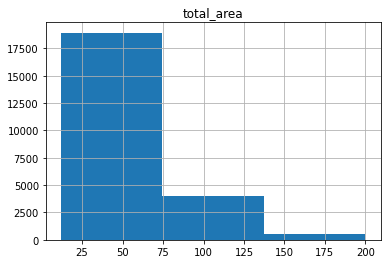

In [47]:
df.total_area.hist(range=(df.total_area.min(), 200), bins=3)
plt.title('total_area')
plt.show()

Как мы видим, большинство проданных квартир имеют площадь от 12 метров до 75 метров. Далее прослеживается тенденция - при увеличении площади недвижимости количество ощутимо падает.

* **Стоимость недвижимости**

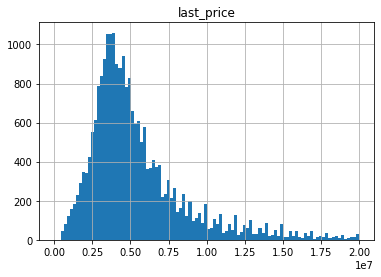

In [48]:
df.last_price.hist(range=(df.last_price.min(), 20000000), bins=100)
plt.title('last_price')
plt.show()

Здесь мы наблюдаем распределение значений, приближенное к нормальному (Гаусса). Основное количество проданных квартир приходится на интервал от 2.5 млн до 5 млн.

* **Количество комнат**

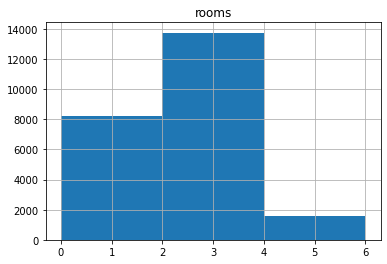

In [49]:
df.rooms.hist(range=(df.rooms.min(), 6), bins=3)
plt.title('rooms')
plt.show()

В таблице преобладают квартиры с 2-4 комнатами, квартир-студий и однокомнатных квартир примерно наполовину меньше. Недвижимость с четырьмя и более комнатами представлена в наименьшем количестве.

* **Высоты потолков**

Здесь в качестве границ диапазона примем значения от 2.3 метров до 5 метров включительно:

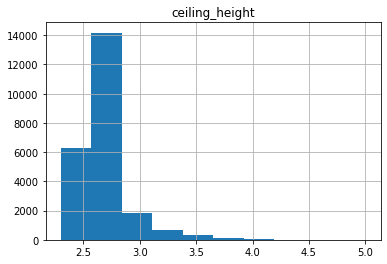

In [50]:
df.ceiling_height.hist(range=(2.3, 5), bins=10)
plt.title('ceiling_height')
plt.show()

Мы наблюдаем, что для подавляющего большинства проданных квартир характерны потолки высотой 2.7 метра, но недвижимость с более низкими потолками составляет половину от этого количества и также имеет место быть.

### Изучение времени продажи квартиры

Перед нами стоит следующий вопрос:

*Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?*

Ранее в **пункте 3** мы выделили из столбца `first_day_exposition` день недели, месяц и год для каждого объявления. Изучим при помощи гистограмм эти параметры и рассмотрим, в какие дни, месяцы и годы объявлений больше всего.

* **Дни недели**

Создадим сводную таблицу по дням недели и построим по ней круговую диаграмму:

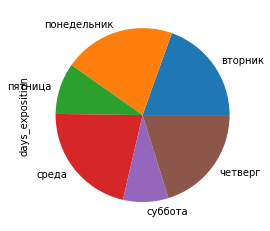

In [51]:
(
    df.pivot_table(
    index='day', 
    values='days_exposition', 
    aggfunc='count')
    .plot(kind='pie', y="days_exposition", legend=False)
)
plt.show()

Здесь мы видим, что большинство объявлений подаётся с понедельника по четверг, т.е. в самые продуктивные рабочие дни. В пятницу и субботу объявлений подаётся наполовину меньше, в воскресение же подач нет - по-видимому, приём объявлений в этот день не производится.

* **Месяцы**

Создадим сводную таблицу по месяцам и построим по ней круговую диаграмму:

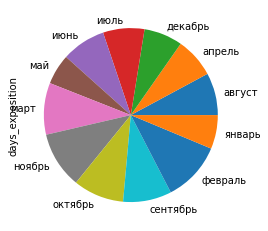

In [52]:
(
    df.pivot_table(
    index='month', 
    values='days_exposition', 
    aggfunc='count')
    .plot(kind='pie', y="days_exposition", legend=False)
)
plt.show()

Чего следовало ожидать, объявления подаются круглый год. Больше всех приходится на февраль, март, сентябрь, октябрь и ноябрь. Когда новогодние праздники позади, а до летнего отпуска ещё далеко, люди чаще прочего задумываются об улучшении жилищных условий.

* **Годы**

Создадим сводную таблицу по годам продаж и построим по ней круговую диаграмму:

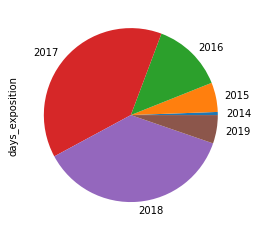

In [53]:
(
    df.pivot_table(
    index='year', 
    values='days_exposition', 
    aggfunc='count')
    .plot(kind='pie', y="days_exposition", legend=False)
)
plt.show()

Здесь же выводы стоит делать не сколько по годам, когда продажи квартир шли хорошо, сколько о работе сервиса "Яндекс Недвижимость". По данным Википедии, с 2014 года сервис перешёл к самостоятельному размещению объявлений, что ознаменовало наблюдаемый по диаграмме рост. Количество объявлений увеличивалось вплоть до 2019 года, после которого резко пошло на спад. Чтобы понять причину данного спада, потребуется изучить, представлены ли данные в датафрейме за весь период 2019 года, либо рассмотреть влияние сторонних факторов.

Далее рассмотрим столбец `days_exposition`. Сперва запросим по нему информацию:

In [54]:
df.days_exposition.describe().to_frame()

,days_exposition
count,20518.000000
mean,180.888634
std,219.727988
min,1.000000
25%,45.000000
50%,95.000000
75%,232.000000
max,1580.000000


Среднее значение составляет 180 дней (полгода), его явно искажает максимум, равный в пересчете 4.5 годам. Медиана внушает куда больше доверия: она составляет 95 дней (три месяца).

Минимальное время, за которое была продана недвижимость, составляет 1 день. Это вызывает вопросы: даже если квартира быстро нашла своего покупателя, срок слишком короткий, чтобы по всем правилам оформить сделку. Стоит запросить подробную информацию по этому объявлению: в данных либо ошибка, либо они заведомо-ложные.

Как упоминалось выше, самая необычная по длительности продажа составляет 4.5 года. Довольно долго, но порой встречаются и такие случаи.

С учётом сводки выше построим гистограмму распределения:

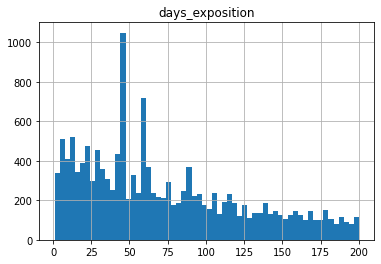

In [55]:
df.days_exposition.hist(range=(df.days_exposition.min(), 200), bins=60)
plt.title('days_exposition')
plt.show()

Распределение данных напоминает распределение Пуассона (что свойственно для временных величин). Однако, в районе 45 и 60 дней наблюдаются аномальные всплески. До того, как их интерпретировать, стоит уточнить у отдела разработки, с чем это может быть связано.  

### Изучение выбросов и составление достоверного среза данных

Следующее на повестке:

*Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили.*

Изучим на предмет выбросов следующие столбцы:

* `total_area`
* `last_price`
* `rooms`
* `ceiling_height`
* `days_exposition`

Сделать это лучше всего через диаграмму размаха ("ящик с усами"). Нарисуем диаграмму и запросим по ней данные для каждого рассматриваемого параметра.

* **Площадь недвижимости**

<AxesSubplot:>

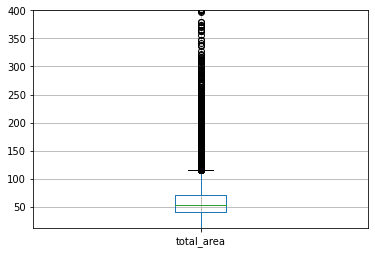

In [56]:
boxplot = df.boxplot('total_area')
plt.ylim(df.total_area.min(), 400)
boxplot

Как мы видим, выбросов со стороны правого "уса" (т.е. квартир с большой площадью) очень много и они оказывают влияние на характер распределения значений. Такой тип можно назвать распределением с тяжёлыми хвостами. Т.е. недвижимость большой площади хоть и встречается редко, но все же имеет значение. Исключив её, мы рискуем сильно обеднить наши данные. Именно по этой причине мы предпочтём не включать данный фактор в наш будущий срез с достоверными данными.

* **Стоимость недвижимости**

<AxesSubplot:>

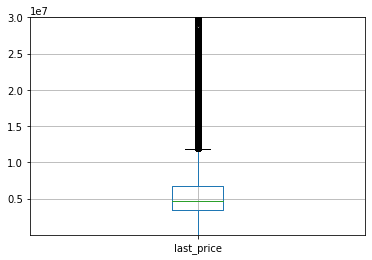

In [57]:
boxplot = df.boxplot('last_price')
plt.ylim(df.last_price.min(), 30000000)
boxplot

Здесь наблюдается огромное число выбросов. Запросим сводку по рассматриваемому столбцу:

In [58]:
df.last_price.describe().to_frame()

,last_price
count,2.369900e+04
mean,6.541549e+06
std,1.088701e+07
min,1.219000e+04
25%,3.400000e+06
50%,4.650000e+06
75%,6.800000e+06
max,7.630000e+08


In [59]:
7.630000e+08

763000000.0

Вопрос установления границ здесь сложен. С одной стороны, данное распределение также относится распределению с тяжёлыми хвостами, которыми нельзя пренебречь. С другой же - максимальная цена за недвижимость означена как 763 млн, а это приводит наше стандартное отклонение к значению почти 11 млн. Последнее при медиане 4.65 млн абсолютно недопустимо.

По этой причине в текущем исследовании мы примем, что оно не включает в себя элитное жильё, и установим правую границу для `last_price` - **100 000 000**.

* **Количество комнат**

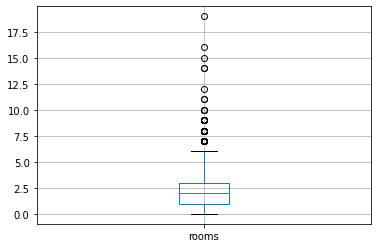

In [60]:
boxplot = df.boxplot('rooms')

Выбросов здесь значительно меньше. Для того, чтобы не обеднять наши данные, мы также исключим этот фактор из влияния на конечный срез.

* **Высоты потолков**

<AxesSubplot:>

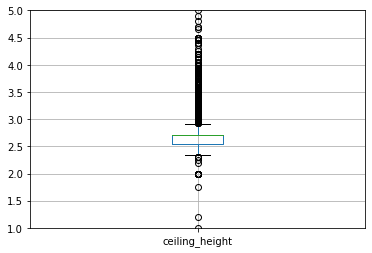

In [61]:
boxplot, data = df.boxplot('ceiling_height', return_type='both')
plt.ylim(df.ceiling_height.min(), 5)
boxplot

Здесь также наблюдается огромное число выбросов, причём с обеих сторон. Запросим данные "ящика с усами" для определения границ межквартильного размаха:

In [62]:
for key, values_list in data.items():
    print(key, [x.get_ydata() for x in values_list])

whiskers [array([2.55, 2.34]), array([2.7 , 2.92])]
caps [array([2.34, 2.34]), array([2.92, 2.92])]
boxes [array([2.55, 2.55, 2.7 , 2.7 , 2.55])]
medians [array([2.7, 2.7])]
fliers [array([2.0, 2.3, 2.0, ..., 3.05, 3.7, 3.0], dtype=object)]
means []


В данном случае назвать это распределением с тяжёлыми хвостами не выйдет: согласно СНиП, потолки в жилой недвижимости не могут быть ниже 2.3 метров. Также можно допустить, что потолков высотой 100 метров в квартире быть не может.

Опираясь на это, установим левую границу для `ceiling_height` - **2.3**, а правую - **5**.

* **Время продажи**

Выведем диаграмму "ящик с усами" и её данные для этого параметра:

<AxesSubplot:>

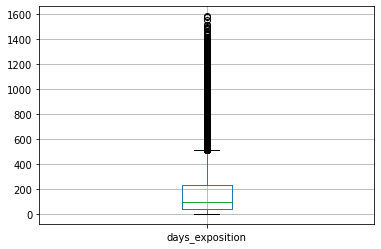

In [63]:
boxplot, data = df.boxplot('days_exposition', return_type='both')
boxplot

Здесь также наблюдается большое число выбросов со стороны правого "уса". Запросим данные "ящика с усами" для определения границ межквартильного размаха:

In [64]:
for key, values_list in data.items():
    print(key, [x.get_ydata() for x in values_list])

whiskers [array([45.,  1.]), array([232., 512.])]
caps [array([1., 1.]), array([512., 512.])]
boxes [array([ 45.,  45., 232., 232.,  45.])]
medians [array([95., 95.])]
fliers [array([558.0, 571.0, 615.0, ..., 721.0000000000001, 519.0, 602.0],
      dtype=object)]
means []


В **пункте 4.2** уже упоминалось, что минимальное время продажи (1 день) весьма и весьма сомнительно, тогда как максимальное (4.5 года) имеет право на существование.

Установим правую границу для `days_exposition` - **7**.

Теперь оценим, какое количество потерь в данных будет, если удалить все значения, охарактеризованные выше как выбросы. Для этого запросим срез с данными, обратившись при помощи `query` и задав все границы, и рассчитаем отношение количества его строк к общему.

Чтобы не лишить нашу выборку весомой части данных, все условия будут рассматриваться совместно:

In [65]:
len(df.query('last_price < 100000000 and 2.3 < ceiling_height < 5 and days_exposition > 7')) / len(df)

0.821469260306342

Потерь оказалось слишком много - около 18%. При формировании достоверного среза данных мы можем пожертвовать не более чем 10% от всего объема; в противном случае наша выборка будет обеднена.

Рассмотрим, какими условиями можно пожертвовать в данной ситуации:

* `ceiling_height` в жилье квартирного типа физически не может быть больше или меньше указанных выше значений, поэтому этот параметр убирать нельзя;

* `last_price` ввиду того, что ранее мы решили исключить недвижимость класса "люкс", также должен присутствовать;

* `days_exposition` и его границами мы можем поступиться, поскольку предположение о связи раннего снятия квартир с продажи с мошеннической деятельностью должно быть проверено в отдельном исследовании.

Уберём условие для `days_exposition` и оценим отношение объёма достоверной выборки к общему:

In [66]:
len(df.query('last_price < 100000000 and 2.3 < ceiling_height < 5')) / len(df)

0.9893666399426136

Мы получили примерно 2% отбракованных данных. Это немного, и результат нас устраивает.

Теперь можно создать срез с достоверными данными `good_data`, запросив его при помощи `query` и задав все границы, перечисленные выше:

In [67]:
good_data = (
    df.query('last_price < 100000000 and 2.3 < ceiling_height < 5')
    .reset_index(drop=True)
)

Выведем информацию о получившемся датафрейме на экран:

In [68]:
good_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23447 entries, 0 to 23446
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23447 non-null  int64         
 1   last_price            23447 non-null  float64       
 2   total_area            23447 non-null  float64       
 3   first_day_exposition  23447 non-null  datetime64[ns]
 4   rooms                 23447 non-null  int64         
 5   ceiling_height        23447 non-null  float64       
 6   floors_total          23363 non-null  float64       
 7   living_area           21583 non-null  float64       
 8   floor                 23447 non-null  int64         
 9   is_apartment          23447 non-null  bool          
 10  studio                23447 non-null  bool          
 11  open_plan             23447 non-null  bool          
 12  kitchen_area          21224 non-null  float64       
 13  balcony         

### Факторы влияния на стоимость квартиры

Наш следующий вопрос звучит так:

*Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра. Также изучите зависимость от даты размещения: дня недели, месяца и года*

В дальнейшем мы будем работать со срезом данных `good_data`, созданным в **пункте 4.3**. Исходя из него, выясним, как соотносятся вышеназванные характеристики с конечной ценой на квартиру и степень их влияния на неё.

* **Связь цены за квартиру с кв.метром**

Для определения взаимосвязи построим *hexbin*-график:

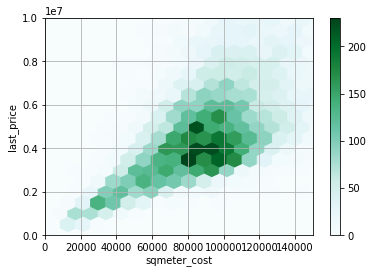

In [69]:
(
    good_data
    .pivot_table(index='sqmeter_cost', values='last_price', aggfunc = 'median')
    .reset_index()
    .plot(x='sqmeter_cost', y='last_price', xlim=(0, 150000), ylim=(0, 10000000), gridsize=(100,100), kind='hexbin', sharex=False, grid=True)
)
plt.show()

Здесь прослеживается повышение частоты встречания определённой цены за квадратный метр (80 тыс. и 100 тыс.) с конечной ценой в 3.5 млн.

Выведем на экран коэффициент корреляции Пирсона:

In [70]:
good_data['last_price'].corr(good_data['sqmeter_cost'])

0.7122471351024503

Значение коэффициента равно 0.7, то есть присутствует сильная взаимосвязь: с повышением цены за кв.метр растет и конечная стоимость недвижимости. С другой стороны, оно и неудивительно: цена за кв.метр вычислена искусственно из стоимости за квартиру, поэтому в полной мере верить этой взаимосвязи нельзя.

* **Связь цены за квартиру с количеством комнат**

Для выяснения связи этого параметра построим иной график:

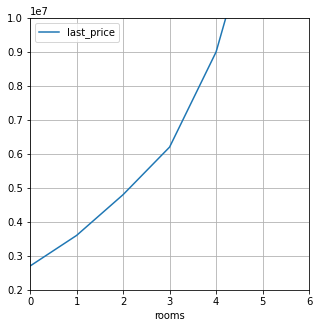

In [71]:
(
    good_data
    .pivot_table(index='rooms', values='last_price', aggfunc = 'median')
    .reset_index()
    .plot(x='rooms', y='last_price', xlim=(0, 6), ylim=(2000000, 10000000), figsize=(5,5), grid=True)
)
plt.show()

Если судить только по графику, то с увеличением количества комнат растёт и стоимость жилья. Но так ли это?

Выведем на экран коэффициент корреляции Пирсона:

In [72]:
good_data['last_price'].corr(good_data['rooms'])

0.4730242956056732

Влияние количество комнат на конечную стоимость неоспоримо, но тем не менее не настолько весомо, чтобы однозначно определять её формирование. В конце концов, в выборке могут присутствовать бывшие общежития с большим количеством комнат, стоимость которых несравнима со стоимостью многокомнатных квартир.

* **Связь цены за квартиру с этажом (первый, последний)**

Построим столбчатую диаграмму:

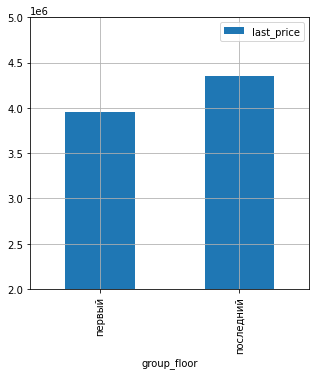

In [73]:
(
    good_data
    .pivot_table(index='group_floor', values='last_price', aggfunc = 'median')
    .reset_index()
    .query('group_floor != "другой"')
    .plot(x='group_floor', y='last_price', ylim=(2000000, 5000000), kind='bar', figsize=(5,5), grid=True)
)
plt.show()

Как видно выше, квартиры на первых этажах в среднем на 20% дешевле, чем на последних (чем красивее вид из окна, тем дороже квартира).

* **Связь цены за квартиру с удалённостью от центра**

Построим диаграмму рассеяния:

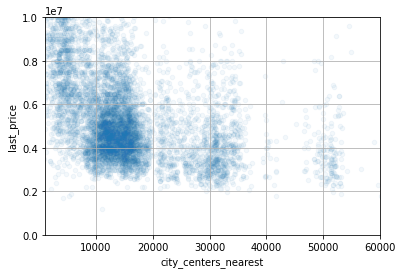

In [74]:
(
    good_data
    .pivot_table(index='city_centers_nearest', values='last_price', aggfunc = 'median')
    .reset_index()
    .plot(x='city_centers_nearest', y='last_price', xlim=(1000, 60000), ylim=(0, 10000000), figsize=(6,4), alpha=0.05, kind='scatter', grid=True)
)
plt.show()

Исходя из картины выше можно судить, что:
* самые дорогие квартиры приходятся на центр города
* наибольшее количество продаваемых квартир приходятся на диапазон от 10 км до 18 км удалённости от центра.

Проверим коэффициент Пирсона для данного параметра:

In [75]:
good_data['last_price'].corr(good_data['city_centers_nearest'])

-0.3010002333283049

Присутствует некоторая отрицательная взаимосвязь, но она нелинейна, и не может однозначно определять конечную стоимость.

* **Связь цены за квартиру с днём недели**

Построим график:

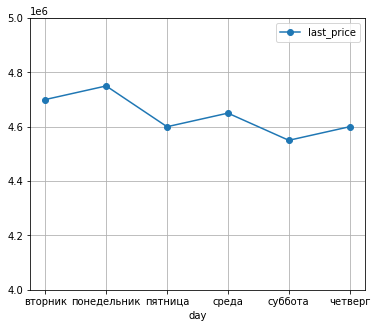

In [76]:
(
    good_data
    .pivot_table(index='day', values='last_price', aggfunc = 'median')
    .reset_index()
    .plot(x='day', y='last_price', ylim=(4000000, 5000000), style='o-', figsize=(6,5), grid=True)
)
plt.show()

Крайне занятная особенность: по графику можно решить, что люди предпочитают снижать стоимость квартир по четвергам, пятницам и субботам.

Для ответа на данный вопрос лучше связаться с отделом разработки, чтобы уточнить, с чем это может быть связано.

* **Связь цены за квартиру с месяцем**

Построим столбчатую диаграмму:

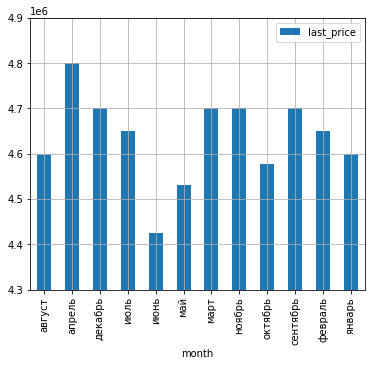

In [77]:
(
    good_data
    .pivot_table(index='month', values='last_price', aggfunc = 'median')
    .reset_index()
    .plot(x='month', y='last_price', ylim=(4300000, 4900000), kind='bar', figsize=(6,5), grid=True)
)
plt.show()

По графику выше можно сказать, что:
* самая высокая стоимость жилья регистрируется в апреле;
* самая низкая - в июне.

На последнее, вероятно, влияет начало сезона отпусков.

* **Связь цены за квартиру с годом**

Построим график:

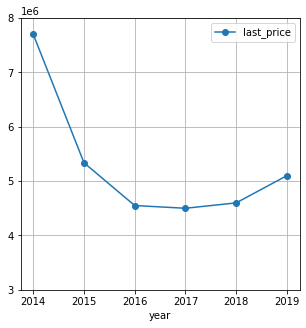

In [78]:
(
    good_data
    .pivot_table(index='year', values='last_price', aggfunc = 'median')
    .reset_index()
    .plot(x='year', y='last_price', ylim=(3000000, 8000000), style='o-', figsize=(5,5), grid=True)
)
plt.show()

Наивысшая медианная стоимость недвижимости приходится на 2014 год. Далее начинается спад, затем - небольшое повышение, начиная с 2019 года.

### Самые популярные населённые пункты

Следующее, что мы рассмотрим:

*Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце `locality_name`*

Для этого поочерёдно выполним следующее:
* сгруппируем данные по `locality_name` и рассчитаем количество объявлений и среднюю стоимость кв.метра, результат сохраним в таблицу `top_10`
* уберём мульти-индекс из названий столбцов новой таблицы их путём переименования
* отсортируем таблицу `top_10` по убыванию количества объявлений, выберем 10 первых населённых пунктов и пересохраним результат обратно в `top_10`

In [79]:
top_10 = (
    good_data
    .pivot_table(index = 'locality_name', values = 'sqmeter_cost', aggfunc=['count', 'mean'])
    .reset_index()
)
top_10.columns = ['locality_name','count', 'mean_sqm_cost']
top_10 = top_10.sort_values('count', ascending = False).head(10)
display(top_10)

,locality_name,count,mean_sqm_cost
33,Санкт-Петербург,15657,113560.376119
227,посёлок Мурино,520,85725.241381
253,посёлок Шушары,440,78677.364217
3,Всеволожск,397,68719.320400
32,Пушкин,369,103125.819291
13,Колпино,338,75424.579098
230,посёлок Парголово,327,90175.913458
6,Гатчина,306,68757.678644
87,деревня Кудрово,299,92473.547576
4,Выборг,235,58238.143141


Из данной выборки десяти наиболее популярных населённых пунктов видно, что самое дорогое жильё находится в Санкт-Петербурге и Пушкине, а самое дешёвое - в Выборге.

Выведем описательную статистику для цены за кв. метр сводной таблицы `top_10`:

In [80]:
top_10.mean_sqm_cost.describe()

count        10.000000
mean      83487.798332
std       16935.425597
min       58238.143141
25%       70424.403757
50%       82201.302799
75%       91899.139046
max      113560.376119
Name: mean_sqm_cost, dtype: float64

В большинстве населённых пунктов стоимость жилья колеблется в пределах от 70 до 92 тыс. за кв.метр. Медианное значение цены составляет 82 тыс. за кв. метр. Это на 33,5 тыс. выше цены за кв. метр в Санкт-Петербурге (самый дорогой и популярный город) - и почти на 22 тыс. ниже, чем в Выборге (самый дешёвый и наименее популярный город выборки). 

Напрашивается вывод: высокая цена на недвижимость напрямую связана с количеством проживающих в населённом пункте людей и, как следствие, его популярностью.

Теперь посмотрим на распределение значений цены за кв.метр `sqmeter_cost` по этим населённым пунктам. Для этого выполним следующее:
* из достоверного среза данных `good_data` запросим все города, указанные в индексах `top_10`;
* по этим данным построим диаграммы "ящик с усами" для `sqmeter_cost` по каждому из городов.

Для более визуального сравнения отобразим все диаграммы на одной плоскости:

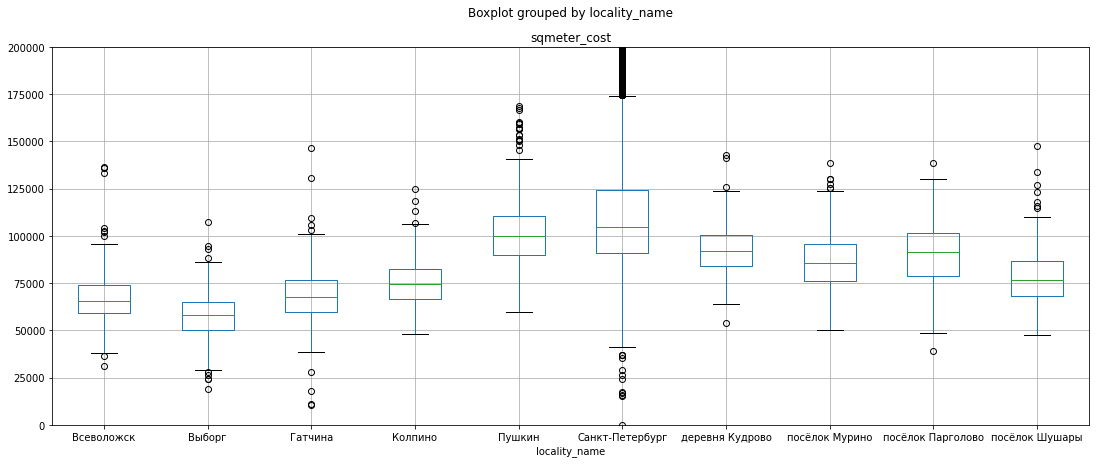

In [81]:
(
    good_data
    .query('locality_name in @top_10.locality_name')
    .boxplot(column='sqmeter_cost', by='locality_name', figsize=(18, 7))
)
plt.ylim(0, 200000)
plt.show()

Выше мы можем наблюдать сразу несколько особенностей:
* колебание медианной цены за кв.метр площади (в Санкт-Петербурге она наивысшая, как мы уже отмечали ранее);
* различная ширина размаха допустимых значений (в Санкт-Петербурге она несравнимо больше, чем в других населённых пунктах);
* наличие выбросов и их количество (в Санкт-Петербурге, опять же, очень много дорогого жилья).

Исходя из этого, имеет смысл рассматривать Санкт-Петербург отдельно от всех остальных городов, что мы в дальнейшем и сделаем.

### Зависимость цены от удалённости от центра (Санкт-Петербург)

Теперь рассмотрим следующее:

*Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге (`locality_name`). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона*

Выполним требуемые действия:

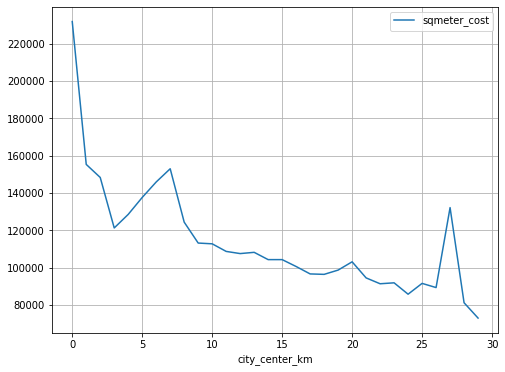

In [82]:
spb_data = good_data.query('locality_name == "Санкт-Петербург"')
spb_data['city_center_km'] = round(spb_data.city_centers_nearest / 1000)
(
    spb_data
    .pivot_table(index='city_center_km', values='sqmeter_cost', aggfunc='mean')
    .reset_index()
    .plot(x='city_center_km', y='sqmeter_cost', figsize=(8,6), grid=True)
)
plt.show()

По графику выше мы видим, что падение цены за кв.метр начинается в районе 7 км удалённости от центра города. Можно считать, это значение и является границей центральной зоны.

Однако, и в районе центра есть области с низкой стоимостью жилья - вероятно, это старые дома и бывшие коммунальные квартиры.

В районе 27 км от центра Санкт-Петербурга наблюдается резкий пик цены за кв. метр площади - по всей видимости, это районы с недавней застройкой элит-класса.

### Сравнение центральной зоны Санкт-Петербурга со всей выборкой
И, наконец, последний пункт нашего исследования:

*Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всей базе?*

Для начала выделим из датафрейма `spb_data` центральную зону (в пределах удалённости 7 км от центра) и запросим по ее параметрам (`total_area`, `last_price`, `rooms`, `ceiling_height`) сводную информацию:

In [83]:
center_data = spb_data.query('city_center_km <= 7')
center_data[['total_area', 'last_price', 'rooms', 'ceiling_height']].describe()

,total_area,last_price,rooms,ceiling_height
count,3483.000000,3.483000e+03,3483.000000,3483.000000
mean,90.865507,1.313732e+07,2.813379,2.948361
std,53.794770,1.230685e+07,1.432243,0.337238
min,12.000000,1.600000e+06,0.000000,2.400000
25%,56.700000,6.650000e+06,2.000000,2.700000
50%,78.000000,9.100000e+06,3.000000,2.800000
75%,108.950000,1.400000e+07,3.000000,3.120000
max,590.000000,9.900000e+07,19.000000,4.800000


Можем заметить следующее:

* *площадь недвижимости*

    Общие площади недвижимости представлены в диапазоне от 12 кв. метров до 590 кв. метров. Медианное значение площади составляет 76 кв. метров, что равносильно трёхкомнатной квартире.
    
    
* *цены*

    Стоимость квартир колеблется от 1.68 млн и до 99 млн включительно. Медианная цена на недвижимость - 8.77 млн.
    

* *количество комнат*

    Минимальное количество комнат - 0 (квартиры-студии), максимальное - 19. Можно допустить, что последние отражают недвижимость нежилого фонда либо общежития. Медианное значение по количеству комнат - 3.
    
    
* *высоты потолков*

    Высоты потолков находятся в диапазоне от 2.4 метра до 4.8 метров включительно. Медиана высоты потолков - 2.75 метра.
    
Мы уже можем наблюдать отличия от анализа по всему объёму выборки, который рассматривался в **пункте 4.1**.

Взглянем поближе на характер распределения параметров. Ниже будут выведены попарно две гистограммы:
* синего цвета - для всей выборки данных,
* оранжевого цвета - для центра Санкт-Петербурга


* **Площадь недвижимости**

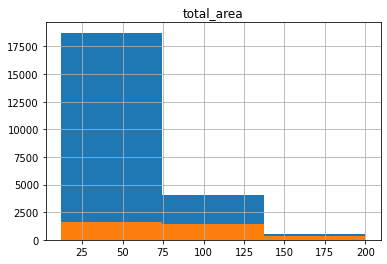

In [84]:
good_data.total_area.hist(range=(df.total_area.min(), 200), bins=3)
center_data.total_area.hist(range=(df.total_area.min(), 200), bins=3)
plt.title('total_area')
plt.show()

Распределения по площадям практически повторяют друг друга - с той лишь разницей, что на центр Санкт-Петербурга приходится меньшее количество объявлений. Кроме того, в центре количество квартир с площадью до 75 кв. метров не намного превышает количество квартир большей площади (75-130 кв. метров) - в отличие от показателей основной выборки, где различие более заметно.

* **Стоимость недвижимости**

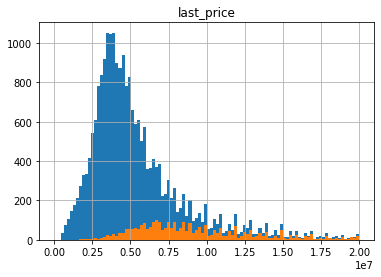

In [85]:
good_data.last_price.hist(range=(df.last_price.min(), 20000000), bins=100)
center_data.last_price.hist(range=(df.last_price.min(), 20000000), bins=100)
plt.title('last_price')
plt.show()

В случае стоимостей недвижимости центр Санкт-Петербурга более равномерный, чем основная выборка - резкие пики в гистограмме отсутствуют. Также график подтверждает отличие медианной цены за жильё в центре города от той же стоимости по всему городу и окрестностям.

* **Количество комнат**

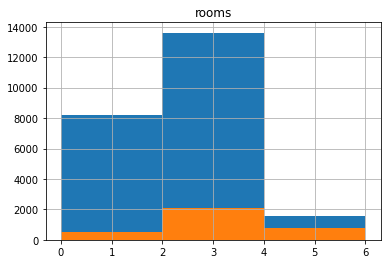

In [86]:
good_data.rooms.hist(range=(df.rooms.min(), 6), bins=3)
center_data.rooms.hist(range=(df.rooms.min(), 6), bins=3)
plt.title('rooms')
plt.show()

В обоих случаях распределения по количеству комнат практически повторяют друг друга - опять же, с поправкой, что на центр Санкт-Петербурга приходится меньшее количество объявлений.

* **Высоты потолков**

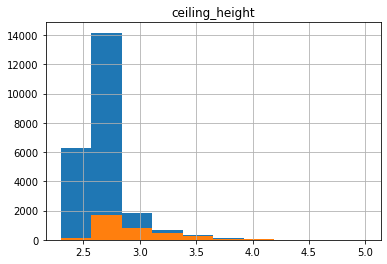

In [87]:
good_data.ceiling_height.hist(range=(2.3, 5), bins=10)
center_data.ceiling_height.hist(range=(2.3, 5), bins=10)
plt.title('ceiling_height')
plt.show()

Из графика выше видно, что в центре Санкт-Петербурга преобладает недвижимость с высокими потолками (от 2.6 до 2.8 метров). Это может быть связано с тем, что там располагаются дома старой застройки, доя которых низкие потолки не характерны. В остальном же распределения практически повторяют друг друга - опять же, с учётом меньшего числа объявлений в центре города.

* **Факторы влияния на стоимость квартиры в центре (число комнат, этаж, удалённость от центра, дата размещения объявления)**

Для определения взаимосвязи с количественными параметрами (число комнат, этаж, удалённость от центра) выведем на экран значения коэффициентов корреляции Пирсона:

In [88]:
center_data[['rooms', 'floor', 'city_centers_nearest', 'last_price']].corr()[['last_price']]

,last_price
rooms,0.400820
floor,0.141106
city_centers_nearest,-0.039929
last_price,1.000000


Мы можем наблюдать лишь условное влияние количества комнат на стоимость квартиры в центре Санкт-Петербурга; впрочем, даже оно не определяет в полной мере конечную стоимость жилья. Вероятно, влияют и иные факторы в совокупности. К примеру, много комнат может быть как у недвижимости элитного класса, так и у бывших общежитий/коммунальных квартир.

Далее рассмотрим влияние дня недели, месяца и года продажи на цену недвижимости в центре Санкт-Петербурга.

* *Связь цены за квартиру в центре с днём недели*

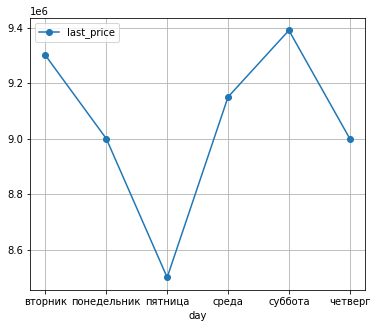

In [89]:
(
    center_data
    .pivot_table(index='day', values='last_price', aggfunc = 'median')
    .reset_index()
    .plot(x='day', y='last_price', style='o-', figsize=(6,5), grid=True)
)
plt.show()

Очень интересная зависимость - стоимость квартиры в пятницу и субботу отличается примерно на 1 млн. Однозначно сказать, чем это может быть вызвано, довольно затруднительно. Лучше запросить уточнения у отдела разработки.

* *Связь цены за квартиру в центре с месяцем*

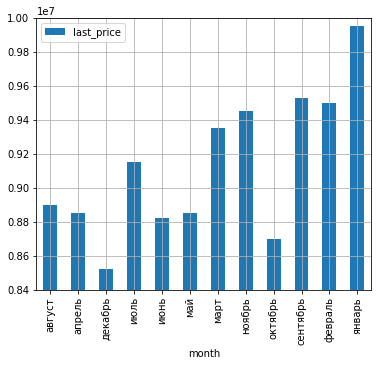

In [90]:
(
    center_data
    .pivot_table(index='month', values='last_price', aggfunc = 'median')
    .reset_index()
    .plot(x='month', y='last_price', ylim=(8400000, 10000000), kind='bar', figsize=(6,5), grid=True)
)
plt.show()

Самые дорогие (9.9 млн) продажи квартир в центре Санкт-Петербурга приходятся на январь, самые дешёвые (около 8.5 млн) - на декабрь.

* *Связь цены за квартиру в центре с годом*

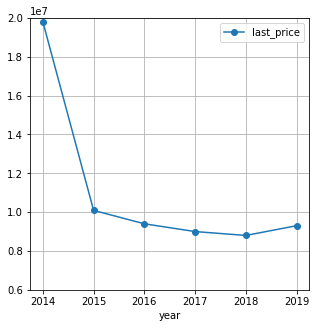

In [91]:
(
    center_data
    .pivot_table(index='year', values='last_price', aggfunc = 'median')
    .reset_index()
    .plot(x='year', y='last_price', ylim=(6000000, 20000000), style='o-', figsize=(5,5), grid=True)
)
plt.show()

Здесь наблюдается та же тенденция, что была в общей выборке: резкое падение стоимости жилья, начиная с 2014 г. Только график куда менее плавный, а медианная цена за 2014 год составляет почти 20 млн (против 7.3 млн по общей выборке).

## Общий вывод
Мы провели масштабное исследование недвижимости Санкт-Петербурга и его окрестностей. Был изучен датафрейм на неполные 24 тыс. наблюдений, содержащий 22 различные характеристики жилой недвижимости.

Исследование велось в несколько этапов:

1. ***Предобработка данных***

* Заголовок `cityCenters_nearest` был приведён к стандартному виду.

* Типы данных были приведены к привычному (в случае с `balcony`) или удобному для анализа виду (`first_day_exposition`).
    
* Пропуски были изучены, оценены и в случаях, где они носили случайный характер, а информация предоставлялась авторами объявлений (`ceiling_height`, `is_apartment`, `balcony`) - заменены. 
    
  Картографические данные (`airports_nearest`, `parks_around3000`, `parks_nearest`, `ponds_around3000`, `ponds_nearest`) ввиду большого количества пропущенных значений и невозможности их замены из дальнейшего исследования пришлось исключить.

  Во всех остальных случаях, для сохранения правдоподобности данных, пропущенные значения были оставлены без изменения.


2. ***Расчёты и добавление результатов в таблицу***

   Были посчитаны и добавлены в таблицу:

    * цена квадратного метра;
    * день недели, месяц и год публикации объявления;
    * этаж квартиры (варианты — первый, последний, другой);
    * соотношение жилой и общей площади, а также отношение площади кухни к общей.
    
   Все характеристики, кроме соотношений площадей, принимали непосредственное участие в дальнейшем исследовательском анализе данных.


3. ***Исследовательский анализ данных***

* **Изучение площади, цены, числа комнат, высоты потолков**   
    
  Исследование показало, что большинство проданных квартир имеют площадь до 75 метров, стоимость от 2.5 млн до 5 млн, количество комнат от 2 до 4 и потолки высотой 2.7 метра.  Наиболее типичной недвижимостью на продажу в Санкт-Петербурге и Ленинградской области является двухкомнатная квартира площадью 52 кв. метра, ценой 4.65 млн и потолками высотой 2.7 метра. 
  

* **Изучение времени продажи квартир**
    
  Медианное время продажи составляет три месяца. Самые необычные по длительности продажи - один день (самая быстрая) и 4.5 года (самая долгая). 
       
  Наибольшее количество заявок подаётся по будням, с понедельника по четверг; в воскресенье объявления не подаются. В разбивке по месяцам всех объявлений приходится на февраль, март, сентябрь, октябрь и ноябрь. 
       
  Для сервиса "Яндекс Недвижимость" самыми продуктивными годами были 2017 и 2018 гг.
   
   
* **Изучение выбросов и составление достоверного среза данных**
    
  Выбросы изучались в столбцах:

    * `total_area`
    * `last_price`
    * `rooms`
    * `ceiling_height`
    * `days_exposition`
       
  Были оценены потери данных при фильтрации и по границам параметров `last_price` и `ceiling_height` подготовлен достоверный срез данных. Отфильтрованные значения составили порядка 2% от всего объёма датасета.
     
     
* **Факторы влияния на стоимость квартиры**
     
  Было выявлено, что на высокую стоимость квартиры влияют большое количество комнат, последний этаж и приближенность к центру города. Однако, все эти связи нелинейны и не могут однозначно определять стоимость - влияет непосредственно совокупность факторов.
       
  По временным характеристикам можно отметить, что люди снижают стоимость квартир по четвергам, пятницам и субботам; самая высокая стоимость жилья регистрируется в апреле, а самая низкая - в июне; самым дорогим с точки зрения цен на квартиры был 2014 год.
       
       
* **Самые популярные населённые пункты**
    
  Был составлен список 10 населённых пунктов с наибольшим числом объявлений, возглавил который Санкт-Петербург, а замкнул Выборг. В этих населённых пунктах стоимость жилья колеблется в пределах от 70 до 92 тыс. за кв.метр. Медианное значение цены составляет примерно 83 тыс. за кв. метр. Это на 33,5 тыс. выше цены за кв. метр в Санкт-Петербурге (самый дорогой и популярный город) - и почти на 22 тыс. ниже, чем в Выборге (самый дешёвый и наименее популярный город выборки).

  Можно сказать, что популярность города и количество проживающих в нём людей является ещё одним фактором, определяющим стоимость недвижимости.
  
  
* **Зависимость цены от удалённости от центра (Санкт-Петербург)**
    
  По соответствующему графику было определено, что граница центральной зоны Санкт-Петербурга - 7 км удалённости от центра города. Именно там цена за недвижимость демонстрирует резкое падение.

  Также было замечено, что в районе 27 км от центра наблюдается резкий пик цены за кв. метр площади - по всей видимости, это районы с недавней застройкой элит-класса.
 
 
* **Сравнение центральной зоны Санкт-Петербурга со всей выборкой**
    
  Типичные квартиры на продажу в центре Санкт-Петербурга в корне отличаются от типичных квартир основной выборки: это уже трёхкомнатная квартира площадью 76 кв. метров, ценой 8.77 млн и потолками высотой 2.75 метра. Стоимость жилья почти вдвое выше значения по всей выборке данных.
    
  На цену квартиры в центре города главным образом влияет число комнат, день и месяц выставления объявления. Стоимость квартиры в пятницу и субботу отличается примерно на 1 млн; самые дорогие (9.9 млн) квартиры приходятся на январь, самые дешёвые (около 8.5 млн) - на декабрь. Относительно годов наблюдается та же динамика, что и по всей выборке в целом - с поправкой лишь на порядок цен за квартиру.
      
      
В целом можно сказать, что предоставленных данных достаточно для создания автоматизированной системы. Однако всё же необходимо запросить некоторые дополнительные данные, для того, чтобы уточнить результаты исследования и сделать данные более достоверными.